# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout



In [3]:
df = pd.read_csv('traffic.csv', parse_dates=['DateTime'])
df.head()

DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041

In [4]:
df.shape

(48120, 4)

In [5]:
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.day_of_week

df = df.set_index('DateTime')
df.drop(['ID'], axis=1, inplace=True)
df.head()


Junction  Vehicles  year  month  day  hour  day_of_week
DateTime                                                                    
2015-11-01 00:00:00         1        15  2015     11    1     0            6
2015-11-01 01:00:00         1        13  2015     11    1     1            6
2015-11-01 02:00:00         1        10  2015     11    1     2            6
2015-11-01 03:00:00         1         7  2015     11    1     3            6
2015-11-01 04:00:00         1         9  2015     11    1     4            6

# 2. EDA

## 2.1 Statistics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48120 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Junction     48120 non-null  int64
 1   Vehicles     48120 non-null  int64
 2   year         48120 non-null  int32
 3   month        48120 non-null  int32
 4   day          48120 non-null  int32
 5   hour         48120 non-null  int32
 6   day_of_week  48120 non-null  int32
dtypes: int32(5), int64(2)
memory usage: 2.0 MB


In [7]:
df.describe()

Junction      Vehicles          year         month           day  \
count  48120.000000  48120.000000  48120.000000  48120.000000  48120.000000   
mean       2.180549     22.791334   2016.269825      5.884289     15.700748   
std        0.966955     20.750063      0.616093      3.569872      8.784073   
min        1.000000      1.000000   2015.000000      1.000000      1.000000   
25%        1.000000      9.000000   2016.000000      3.000000      8.000000   
50%        2.000000     15.000000   2016.000000      5.000000     16.000000   
75%        3.000000     29.000000   2017.000000      9.000000     23.000000   
max        4.000000    180.000000   2017.000000     12.000000     31.000000   

               hour   day_of_week  
count  48120.000000  48120.000000  
mean      11.500000      2.996010  
std        6.922258      2.000017  
min        0.000000      0.000000  
25%        5.750000      1.000000  
50%       11.500000      3.000000  
75%       17.250000      5.000000  
max       23.000000      6.000000

## 2.2 Data Analysis

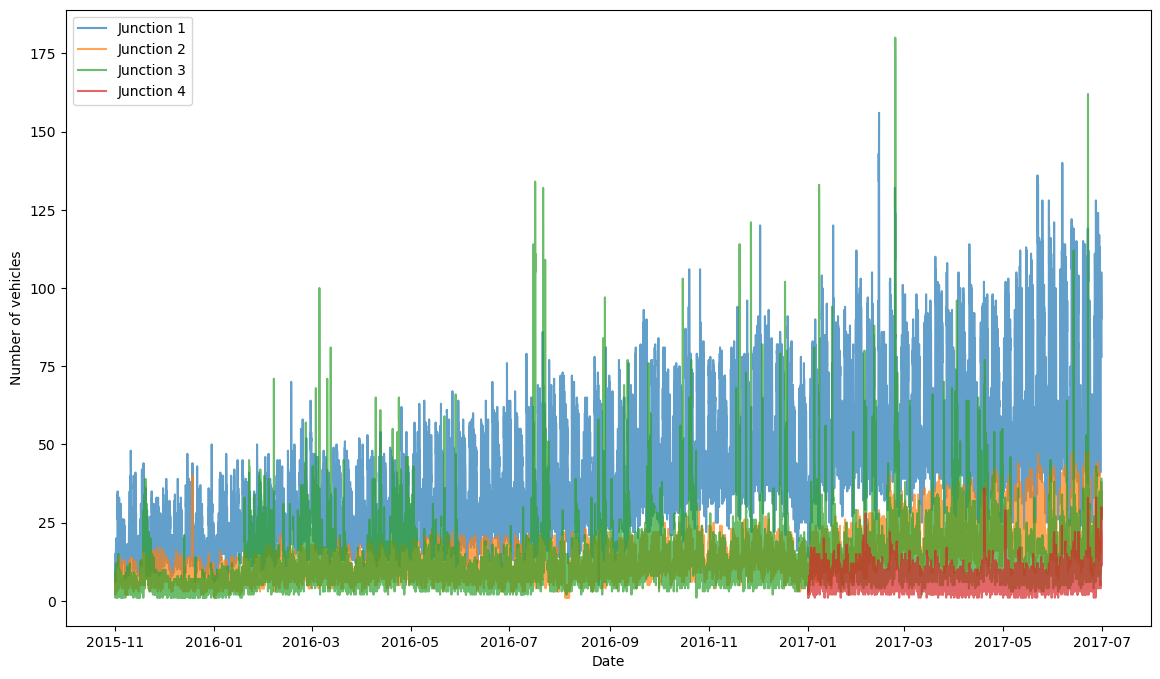

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

for i in range(4):
    ax.plot(df[df['Junction'] == i+1]['Vehicles'], alpha=0.7, label=f'Junction {i+1}')

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of vehicles')
plt.show()

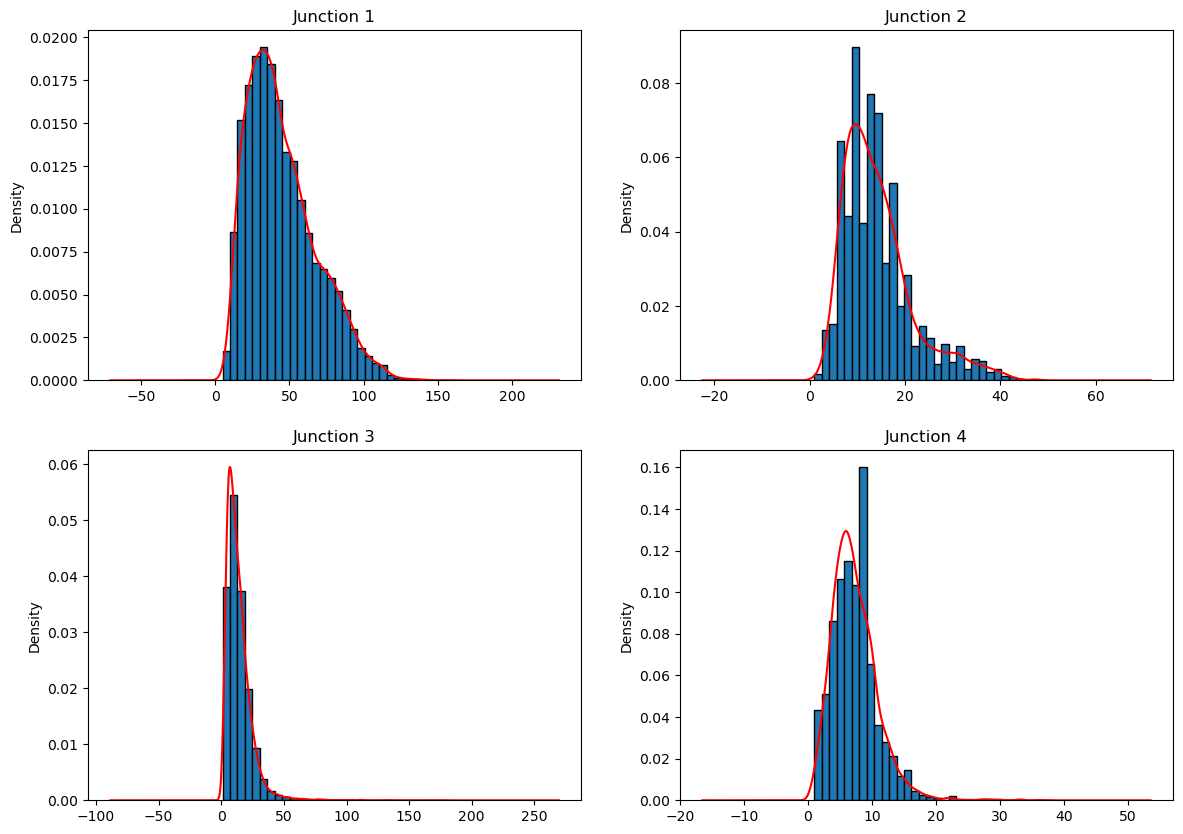

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

for i in range(4):
    cur_ax = ax[i // 2][i % 2]
    df[df['Junction'] == i+1]['Vehicles'].plot(kind='hist', ax=cur_ax, grid=False, bins=30, edgecolor='black', density=True)
    df[df['Junction'] == i+1]['Vehicles'].plot(kind='kde', ax=cur_ax, color='red')
    cur_ax.set_title(f'Junction {i+1}')

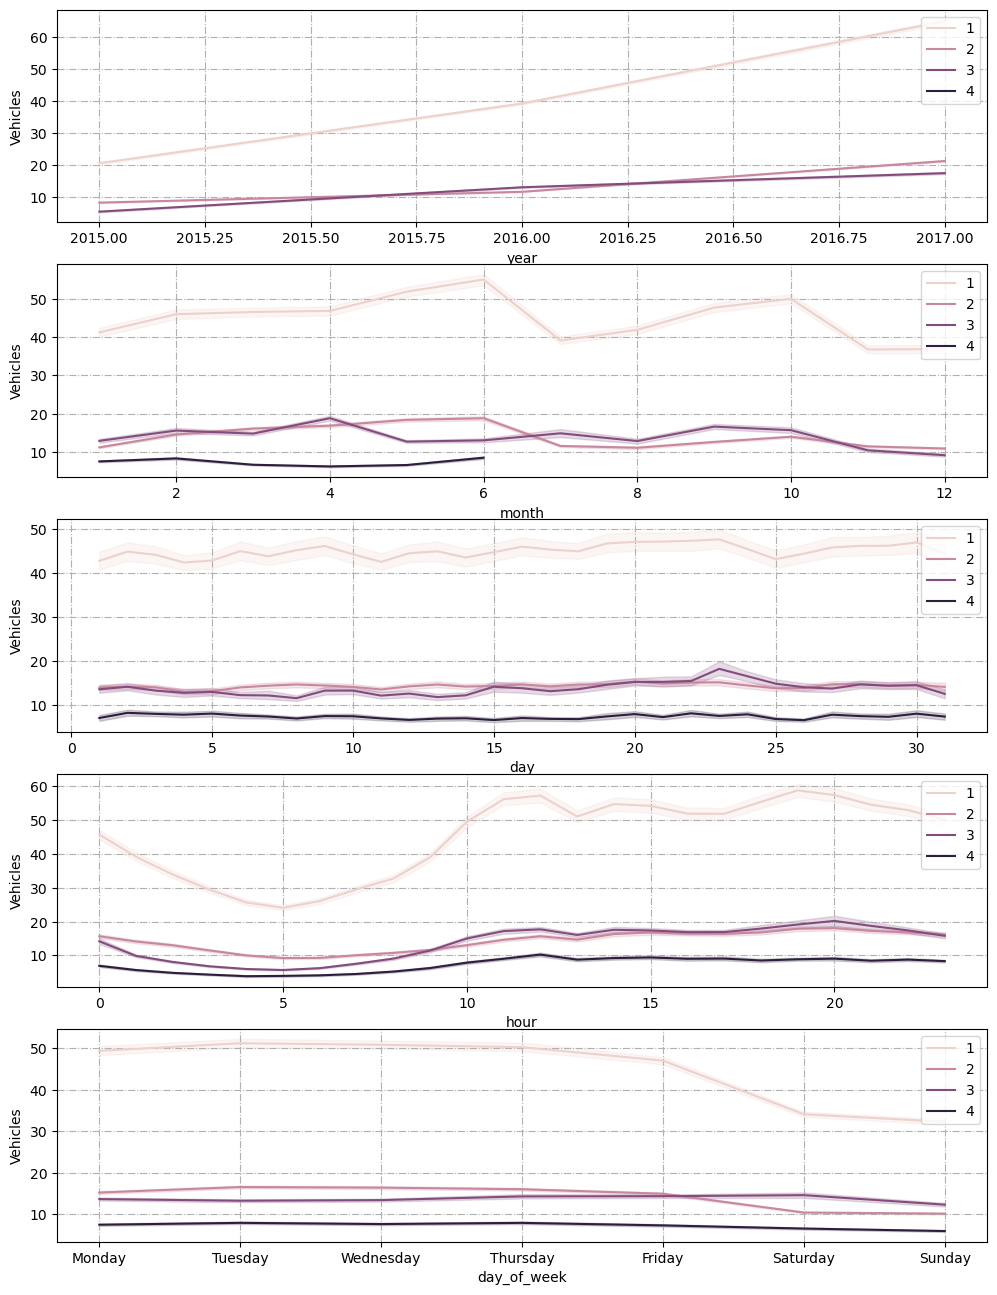

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 16))
features = df.columns[-5:]

for i, f in enumerate(features):
    sns.lineplot(ax=ax[i], x=f, y='Vehicles', hue='Junction', data=df)
    ax[i].legend(loc='upper right')
    ax[i].grid(True, ls='-.')

ax[4].set_xticks(range(7))
ax[4].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

## 2.3 Correlation Analysis

In [11]:
corrs = df.corr()
corrs

Junction  Vehicles          year         month           day  \
Junction     1.000000e+00 -0.613787  2.212977e-01 -1.242771e-01 -2.094621e-03   
Vehicles    -6.137872e-01  1.000000  2.212531e-01 -2.272345e-02  2.789498e-02   
year         2.212977e-01  0.221253  1.000000e+00 -6.234957e-01 -7.474779e-03   
month       -1.242771e-01 -0.022723 -6.234957e-01  1.000000e+00  9.154760e-03   
day         -2.094621e-03  0.027895 -7.474779e-03  9.154760e-03  1.000000e+00   
hour        -2.132575e-15  0.219938  7.732006e-16  4.953278e-16 -9.917806e-18   
day_of_week -6.590970e-04 -0.126027  1.278526e-03 -3.208219e-03 -8.628855e-04   

                     hour   day_of_week  
Junction    -2.132575e-15 -6.590970e-04  
Vehicles     2.199377e-01 -1.260265e-01  
year         7.732006e-16  1.278526e-03  
month        4.953278e-16 -3.208219e-03  
day         -9.917806e-18 -8.628855e-04  
hour         1.000000e+00  6.442124e-18  
day_of_week  6.442124e-18  1.000000e+00

<Axes: >

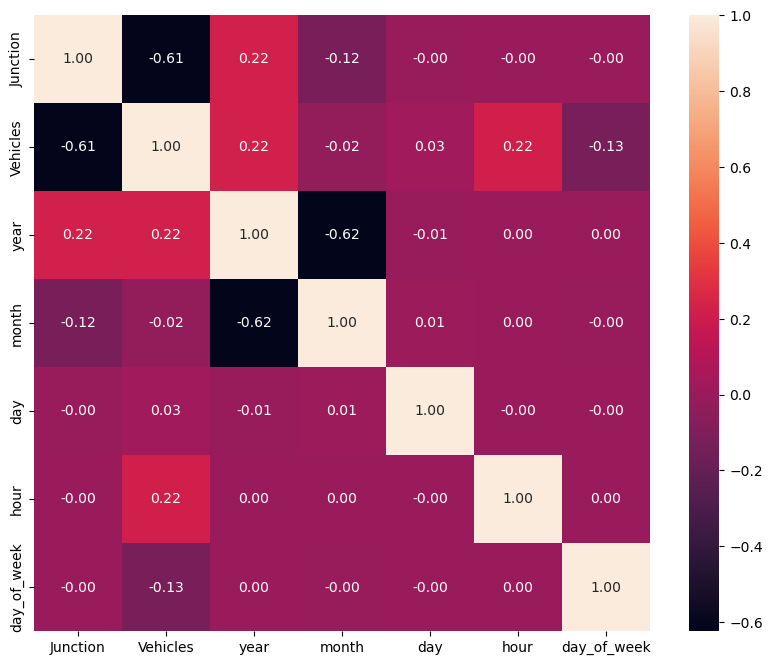

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrs, vmax=1, square=True, annot=True, fmt='.2f', ax=ax)

## 2.4 Outlier Check

<Axes: xlabel='Junction', ylabel='Vehicles'>

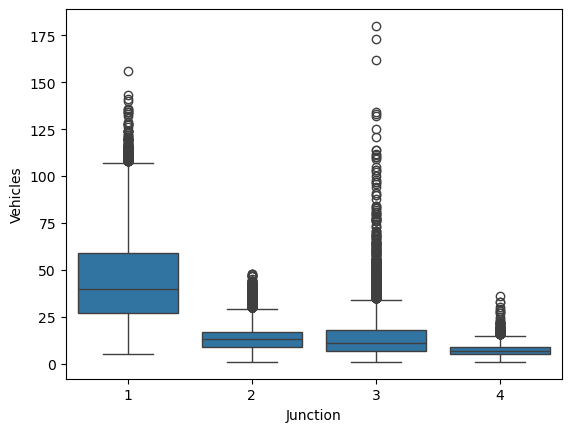

In [13]:
sns.boxplot(x='Junction', y='Vehicles', data=df)

## 2.5 Correlation Pairplots

c:\Users\Kanam\Programming\Python\Env\envs\ML\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


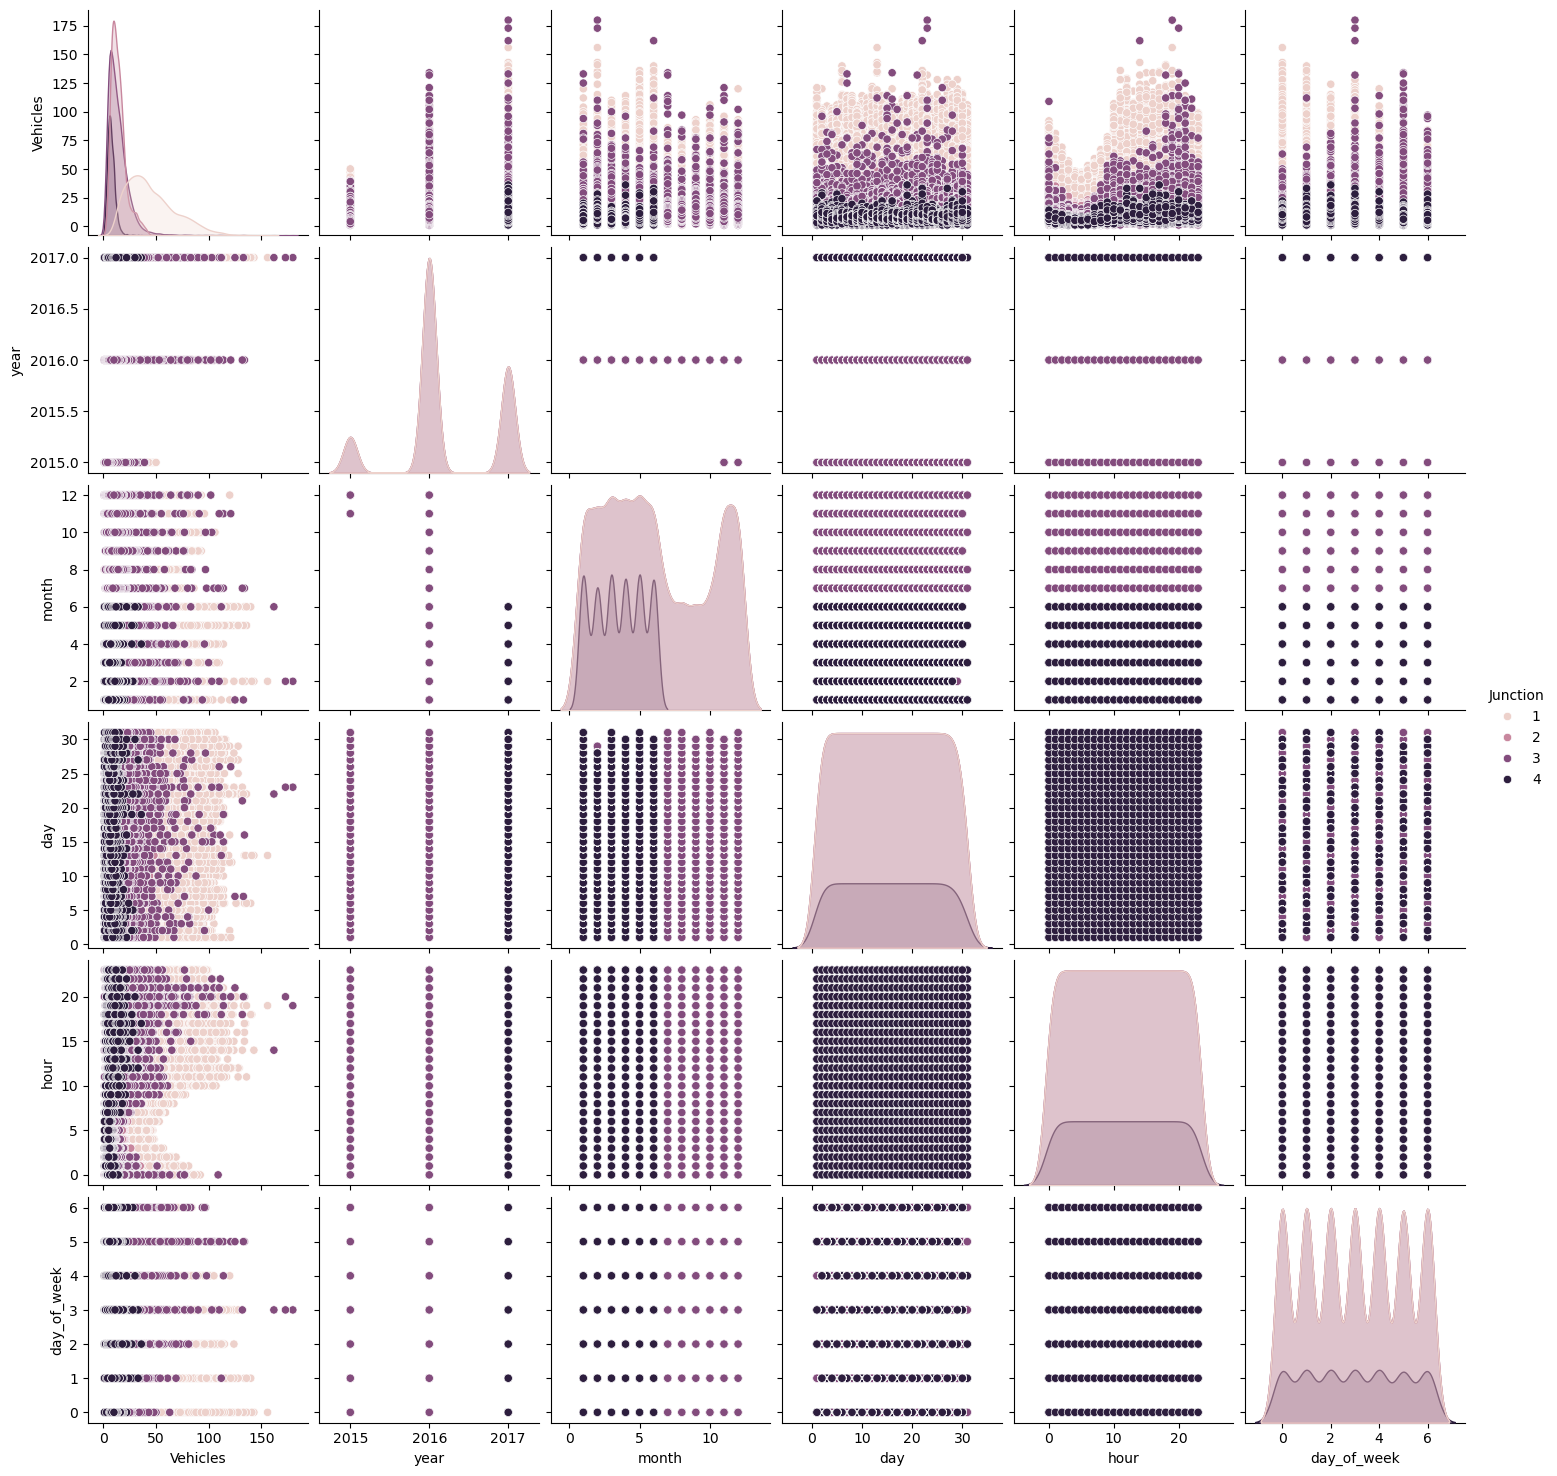

In [14]:
sns.pairplot(df, hue='Junction')

# 3. Data Preprocessing

## 3.1 Normalisation

In [15]:
df_transformed = df.copy()
scaler = StandardScaler()
df_transformed.loc[:,'Vehicles'] = scaler.fit_transform(df_transformed[['Vehicles']])
df_transformed

Junction  Vehicles  year  month  day  hour  day_of_week
DateTime                                                                    
2015-11-01 00:00:00         1 -0.375489  2015     11    1     0            6
2015-11-01 01:00:00         1 -0.471875  2015     11    1     1            6
2015-11-01 02:00:00         1 -0.616454  2015     11    1     2            6
2015-11-01 03:00:00         1 -0.761034  2015     11    1     3            6
2015-11-01 04:00:00         1 -0.664648  2015     11    1     4            6
...                       ...       ...   ...    ...  ...   ...          ...
2017-06-30 19:00:00         4 -0.568261  2017      6   30    19            4
2017-06-30 20:00:00         4  0.347408  2017      6   30    20            4
2017-06-30 21:00:00         4 -0.327296  2017      6   30    21            4
2017-06-30 22:00:00         4 -0.038137  2017      6   30    22            4
2017-06-30 23:00:00         4 -0.520068  2017      6   30    23            4

[48120 rows x 7 columns]

## 3.2 Outlier Removal

In [16]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    LB = Q1 - 1.5 * (Q3 - Q1)
    UB = Q3 + 1.5 * (Q3 - Q1)
    return df[(df[column] >= LB) & (df[column] <= UB)]


In [17]:
data = [df_transformed[df_transformed['Junction'] == i] for i in range(1, 5)]
data = [remove_outliers(d, 'Vehicles') for d in data]
data[3]

Junction  Vehicles  year  month  day  hour  day_of_week
DateTime                                                                    
2017-01-01 00:00:00         4 -0.953806  2017      1    1     0            6
2017-01-01 01:00:00         4 -1.050193  2017      1    1     1            6
2017-01-01 02:00:00         4 -0.905613  2017      1    1     2            6
2017-01-01 03:00:00         4 -0.905613  2017      1    1     3            6
2017-01-01 04:00:00         4 -1.001999  2017      1    1     4            6
...                       ...       ...   ...    ...  ...   ...          ...
2017-06-30 13:00:00         4 -0.568261  2017      6   30    13            4
2017-06-30 14:00:00         4 -0.616454  2017      6   30    14            4
2017-06-30 15:00:00         4 -0.423682  2017      6   30    15            4
2017-06-30 19:00:00         4 -0.568261  2017      6   30    19            4
2017-06-30 23:00:00         4 -0.520068  2017      6   30    23            4

[4247 rows x 7 columns]

## 3.3 Stationarity Test

In [18]:
info = {
    'ADF statistic': [],
    'p-value': [],
    '1% critical value': [],
    '5% critical value': [], 
    '10% critical value': [],
    'Stationarity': []
}
for i in range(4):
    adf = adfuller(data[i]['Vehicles'])
    info['ADF statistic'].append(adf[0])
    info['p-value'].append(adf[1])
    info['1% critical value'].append(adf[4]['1%'])
    info['5% critical value'].append(adf[4]['5%'])
    info['10% critical value'].append(adf[4]['10%'])
    info['Stationarity'].append(adf[0] < adf[4]['1%'])

    print(f'Junction {i + 1}')
    print(f'ADF statistic: {adf[0]}')
    print(f'p-value: {adf[1]}')
    print('Critical values:')
    print(adf[4])
    print('The time series is stationary' if adf[0] < adf[4]['1%'] else 'The time series is Non-stationary')
    print('-' * 100)

Junction 1
ADF statistic: -7.366837274914815
p-value: 9.189059667381003e-11
Critical values:
{'1%': -3.4308044515512717, '5%': -2.861740847302983, '10%': -2.56687690627973}
The time series is stationary
----------------------------------------------------------------------------------------------------
Junction 2
ADF statistic: -9.151651477049692
p-value: 2.6764975816478228e-15
Critical values:
{'1%': -3.4308303564367497, '5%': -2.861752295180205, '10%': -2.5668829998752503}
The time series is stationary
----------------------------------------------------------------------------------------------------
Junction 3
ADF statistic: -6.614106541592318
p-value: 6.269937439103259e-09
Critical values:
{'1%': -3.430814655649843, '5%': -2.861745356706292, '10%': -2.5668793065899074}
The time series is stationary
----------------------------------------------------------------------------------------------------
Junction 4
ADF statistic: -6.378743962849142
p-value: 2.2496397220989482e-08
Critica

In [19]:
info_df = pd.DataFrame(info)
info_df.index = [f'Junction {i}' for i in range(1, 5)]
info_df

ADF statistic       p-value  1% critical value  5% critical value  \
Junction 1      -7.366837  9.189060e-11          -3.430804          -2.861741   
Junction 2      -9.151651  2.676498e-15          -3.430830          -2.861752   
Junction 3      -6.614107  6.269937e-09          -3.430815          -2.861745   
Junction 4      -6.378744  2.249640e-08          -3.431901          -2.862225   

            10% critical value  Stationarity  
Junction 1           -2.566877          True  
Junction 2           -2.566883          True  
Junction 3           -2.566879          True  
Junction 4           -2.567135          True

# 4. Modelling

In [20]:
class Model:
    def __init__(self, model, df, test_size, features, target, name, params, cv_check=True):
        self.df = df
        self.model = model
        self.test_size = test_size
        self.features = features
        self.target = target
        self.name = name
        self.params = params
        self.cv_check = cv_check
    
    def split(self, seed=42):
        X = self.df[self.features]
        y = self.df[self.target]
        return train_test_split(X, y, test_size=self.test_size, random_state=seed)
    
    def evaluate(self, actual_val, prediction):
        rmse = MSE(actual_val, prediction, squared=False)
        mae = MAE(actual_val, prediction)
        r2_value = r2_score(actual_val, prediction)
        return rmse, mae, r2_value

    def param_tuning(self, X, y, n_splits=3):
        tscv = TimeSeriesSplit(n_splits)
        gsearch = GridSearchCV(estimator=self.model, param_grid=self.params, cv=tscv, n_jobs=-1)
        gsearch.fit(X, y)
        return gsearch

    def run(self, table):
        X_train, self.X_test, y_train, self.y_test = self.split()
        if self.cv_check:
            best_params = self.param_tuning(X_train, y_train).best_params_
            self.model.set_params(**best_params)
        self.model.fit(X_train, y_train)
        y_predict = self.model.predict(self.X_test)
        
        rmse, mae, r2_value = self.evaluate(self.y_test, y_predict)
        table.loc[self.name] = [rmse, mae, r2_value]
        return y_predict, table
    
    def feature_importances(self):
        importances_df = pd.DataFrame(self.model.feature_importances_, index=self.features, columns=['importance'])
        return importances_df


In [21]:
def show(y_test, y_pred, ax, i):
    ax.plot(scaler.inverse_transform(np.array(y_test[:250]).reshape(-1, 1)), alpha=0.5, label='actual')
    ax.plot(scaler.inverse_transform(np.array(y_pred[:250]).reshape(-1, 1)), alpha=0.8, label='predicted', linestyle='-.')
    ax.legend(loc='upper right')
    ax.set_ylabel('Vehicles')
    ax.set_title(f'Junction {i}')


def show1(Y_test, res):
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 16), sharey=True)
    for i in range(4):
        ax[i][0].plot(scaler.inverse_transform(np.array(Y_test[i]).reshape(-1, 1)), label='actual')
        ax[i][1].plot(scaler.inverse_transform(np.array(res[i]).reshape(-1, 1)), label='predicted', linestyle='-.')
        ax[i][0].legend(loc='upper right')
        ax[i][1].legend(loc='upper right')
        ax[i][0].set_ylabel('Vehicles')
        


## 4.1 Random Forest

0 [ 2.48971196  0.18127592 -0.1852112  ...  0.99155824  0.43213855
  3.16684674]
y_test: DateTime
2017-01-05 11:00:00    3.238996
2015-12-08 19:00:00    0.058249
2016-02-28 02:00:00   -0.134523
2016-08-07 00:00:00    0.202829
2016-02-22 02:00:00    0.058249
                         ...   
2016-11-20 21:00:00    1.552236
2017-03-17 19:00:00    2.949837
2017-02-16 04:00:00    0.732953
2015-12-21 10:00:00    0.058249
2017-01-09 16:00:00    3.142609
Name: Vehicles, Length: 2887, dtype: float64
1 [-0.82824941 -0.53695918 -0.80578548 ... -0.67250564  0.10212577
 -0.40877233]
y_test: DateTime
2016-08-14 07:00:00   -0.857420
2017-03-12 05:00:00   -0.520068
2016-08-27 07:00:00   -0.809227
2017-02-27 18:00:00    0.251022
2016-08-20 05:00:00   -0.712841
                         ...   
2016-08-26 12:00:00   -0.423682
2016-12-10 16:00:00   -0.520068
2016-03-28 01:00:00   -0.857420
2017-04-28 01:00:00    0.154636
2016-08-29 11:00:00   -0.568261
Name: Vehicles, Length: 2732, dtype: float64
2 [-0.6293

RMSE       MAE       R^2
Junction 1  0.185797  0.136094  0.968583
Junction 2  0.099772  0.080631  0.854158
Junction 3  0.152084  0.114155  0.806105
Junction 4  0.096277  0.077159  0.550362

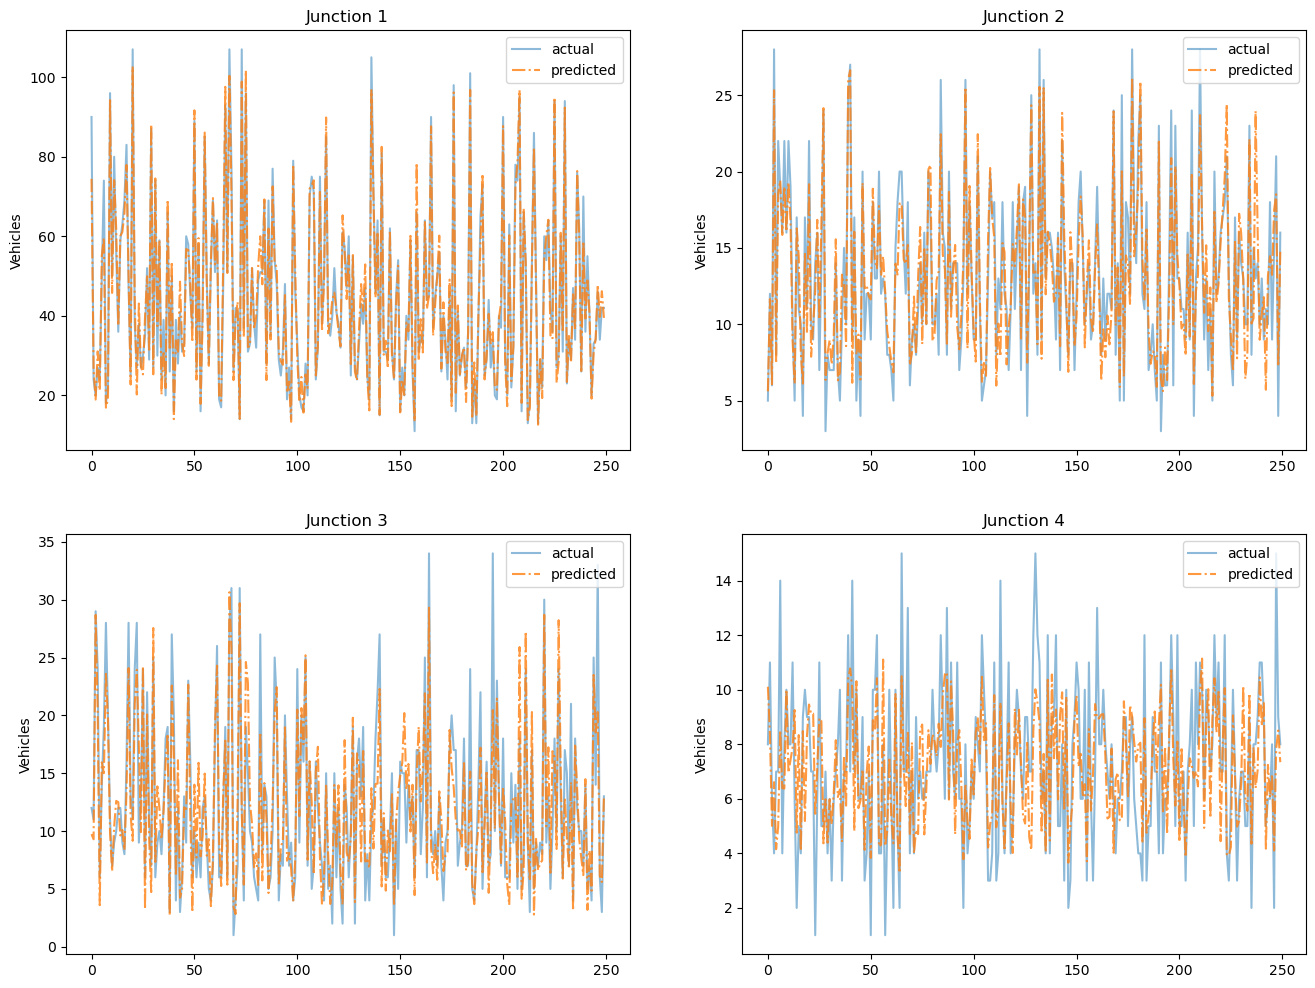

In [22]:
table_rf = pd.DataFrame(np.zeros((4, 3)), columns=['RMSE', 'MAE', 'R^2'], index=[f'Junction {i}' for i in range(1, 5)])
param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 10],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2, 4],
              'max_features': [None, 'sqrt', 'log2'],
            }

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
rfrs = []
res1 = []
for i in range(4):
    model = Model(RandomForestRegressor(random_state=42), data[i], 0.2, 
    data[i].columns.drop(['Junction', 'Vehicles']), 'Vehicles',
    f'Junction {i+1}', param_grid, True)
    y_predict, table_rf = model.run(table_rf)
    rfrs.append(model)
    res1.append(y_predict)
    print(i, y_predict)
    print('y_test:', model.y_test)

    cur_ax = ax[i // 2][i % 2]
    show(model.y_test,y_predict, ax=cur_ax, i=i+1)

table_rf


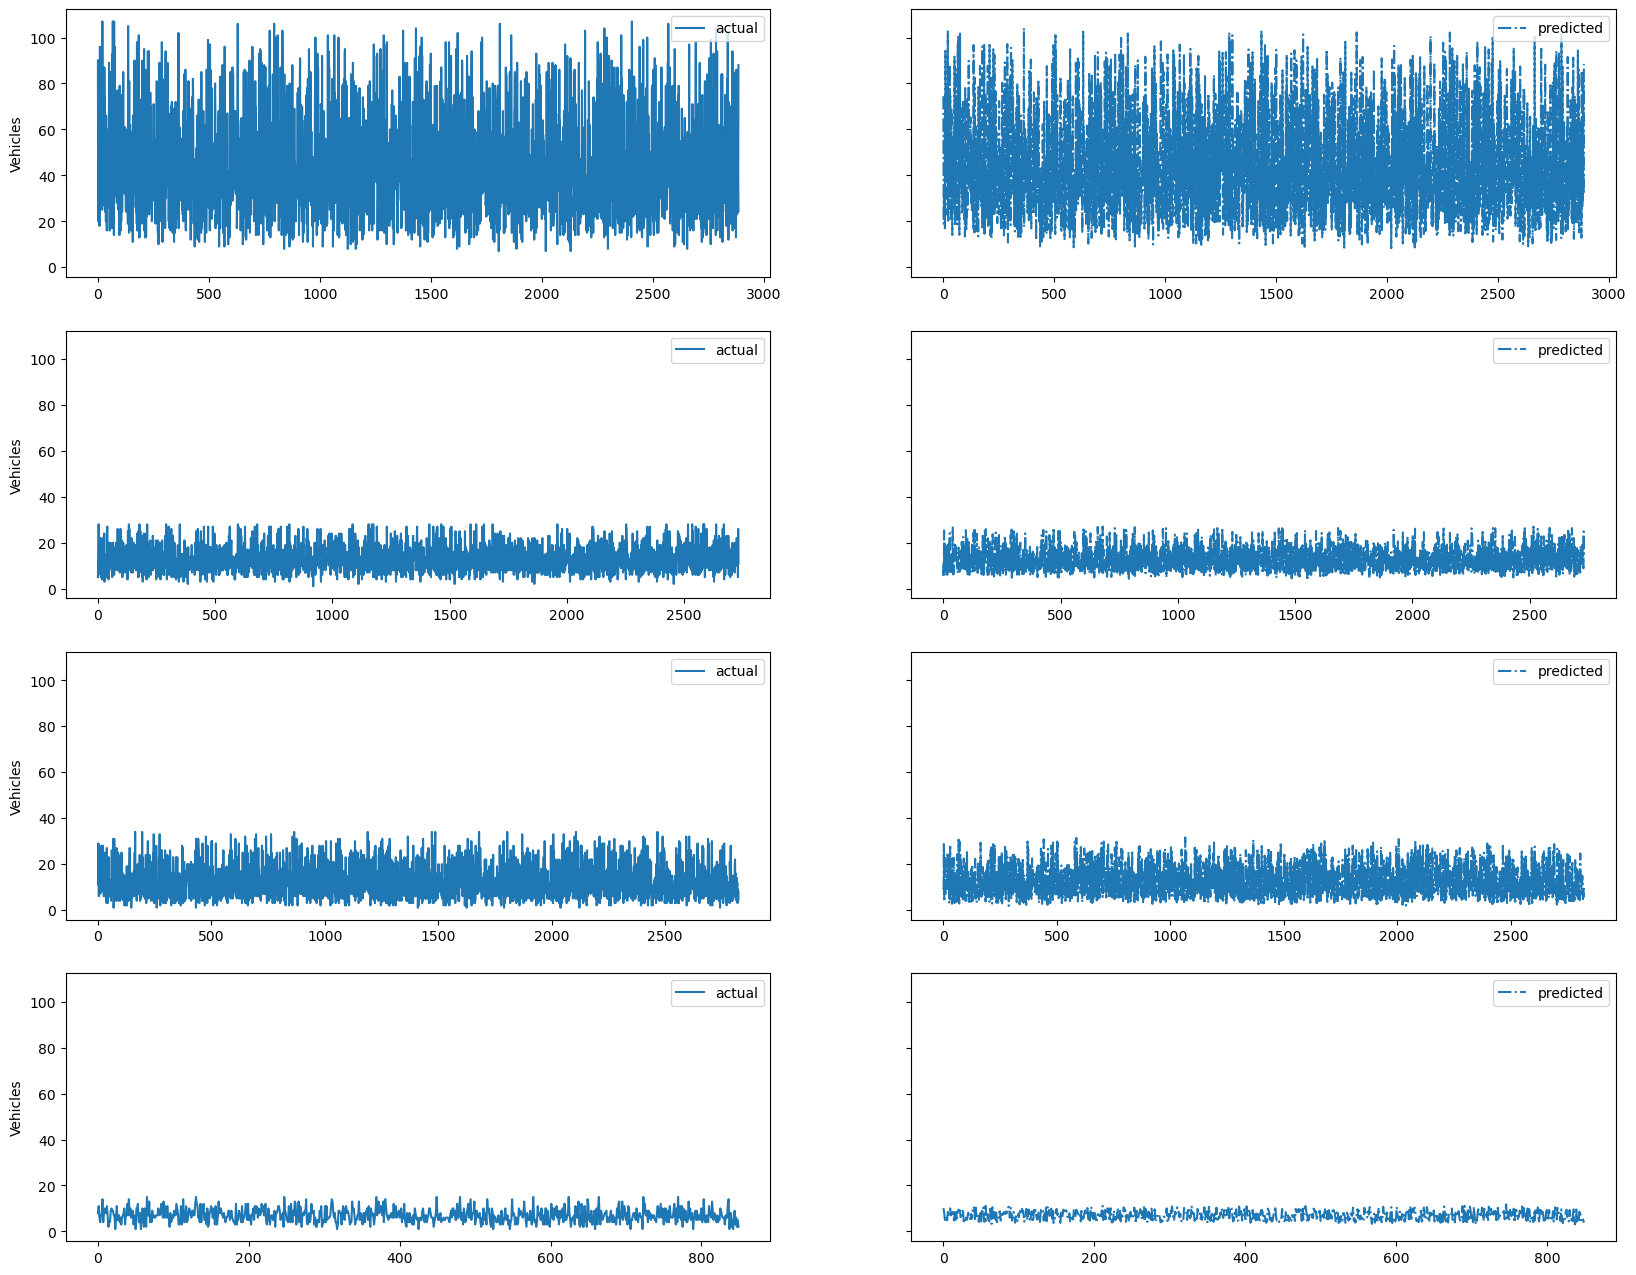

In [23]:
show1( [rfrs[i].y_test for i in range(4)], res1)

### Fearure Importance

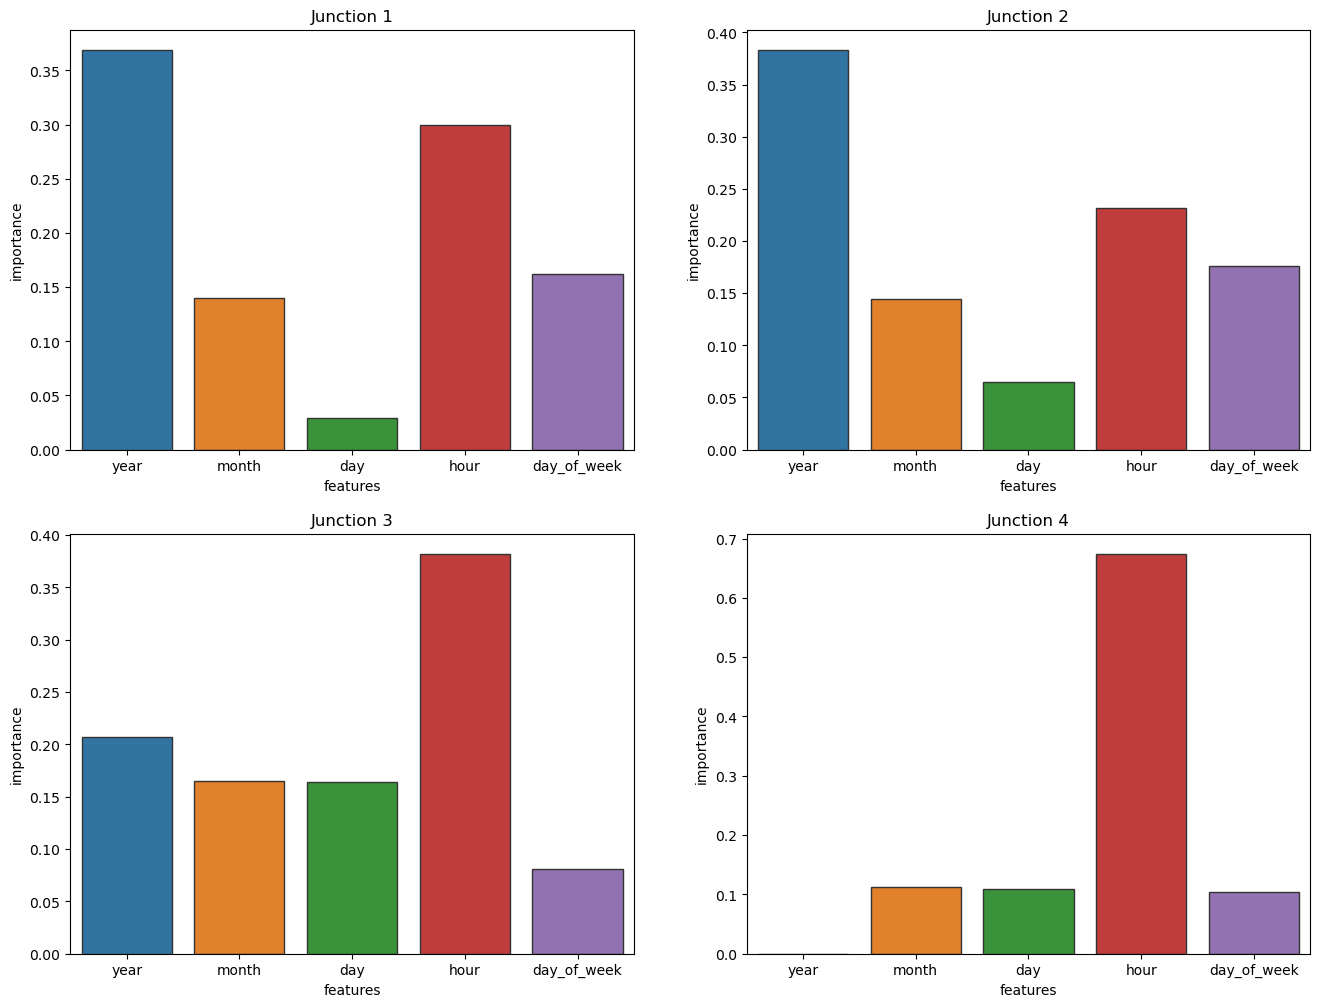

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), )
for i in range(4):
    cur_ax = ax[i // 2][i % 2]
    importances = rfrs[i].feature_importances().reset_index()
    sns.barplot(x='index', y='importance', hue='index', data=importances, edgecolor='.2', ax=cur_ax)
    #rfrs[i].feature_importances().plot(kind='bar', ax=cur_ax)
    cur_ax.set_title(f'Junction {i+1}')
    cur_ax.set_xlabel('features')


## 4.2 XGBoost

0 [ 2.6698332   0.20538391 -0.1442027  ...  0.9317038   0.435615
  3.228947  ]
y_test: DateTime
2017-01-05 11:00:00    3.238996
2015-12-08 19:00:00    0.058249
2016-02-28 02:00:00   -0.134523
2016-08-07 00:00:00    0.202829
2016-02-22 02:00:00    0.058249
                         ...   
2016-11-20 21:00:00    1.552236
2017-03-17 19:00:00    2.949837
2017-02-16 04:00:00    0.732953
2015-12-21 10:00:00    0.058249
2017-01-09 16:00:00    3.142609
Name: Vehicles, Length: 2887, dtype: float64
1 [-0.8096072  -0.5409693  -0.7946602  ... -0.68997306  0.13300012
 -0.45569426]
y_test: DateTime
2016-08-14 07:00:00   -0.857420
2017-03-12 05:00:00   -0.520068
2016-08-27 07:00:00   -0.809227
2017-02-27 18:00:00    0.251022
2016-08-20 05:00:00   -0.712841
                         ...   
2016-08-26 12:00:00   -0.423682
2016-12-10 16:00:00   -0.520068
2016-03-28 01:00:00   -0.857420
2017-04-28 01:00:00    0.154636
2016-08-29 11:00:00   -0.568261
Name: Vehicles, Length: 2732, dtype: float64
2 [-0.66203 

RMSE       MAE       R^2
Junction 1  0.160826  0.118774  0.976460
Junction 2  0.096871  0.078442  0.862516
Junction 3  0.144437  0.109803  0.825113
Junction 4  0.097251  0.077759  0.541212

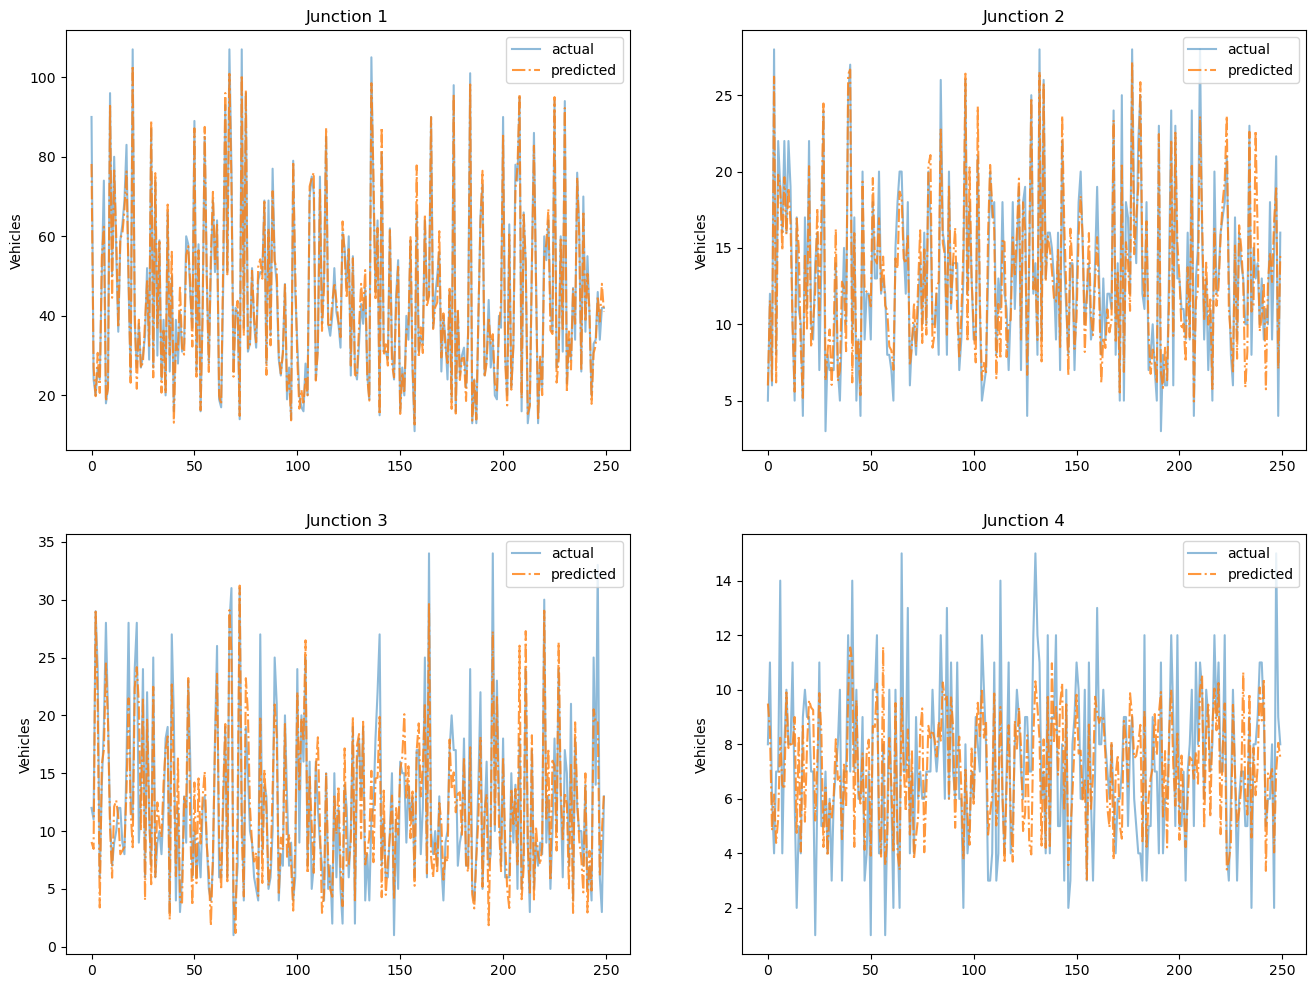

In [25]:
table_xbg = pd.DataFrame(np.zeros((4, 3)), columns=['RMSE', 'MAE', 'R^2'], index=[f'Junction {i}' for i in range(1, 5)])
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [3, 5, 7, 9],
              'eta': [0.01, 0.1, 0.2, 0.3],
              'subsample': [0.8, 1],
            }

xgbs = []
res2 = []

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
for i in range(4):
    model = Model(XGBRegressor(objective='reg:squarederror', random_state=42), data[i], 0.2, 
    data[i].columns.drop(['Junction', 'Vehicles']), 'Vehicles',
    f'Junction {i+1}', param_grid)
    y_predict, table_xbg = model.run(table_xbg)
    res2.append(y_predict)
    xgbs.append(model)

    print(i, y_predict)
    print('y_test:', model.y_test)

    cur_ax = ax[i // 2][i % 2]
    show(model.y_test,y_predict, ax=cur_ax, i=i+1)

table_xbg

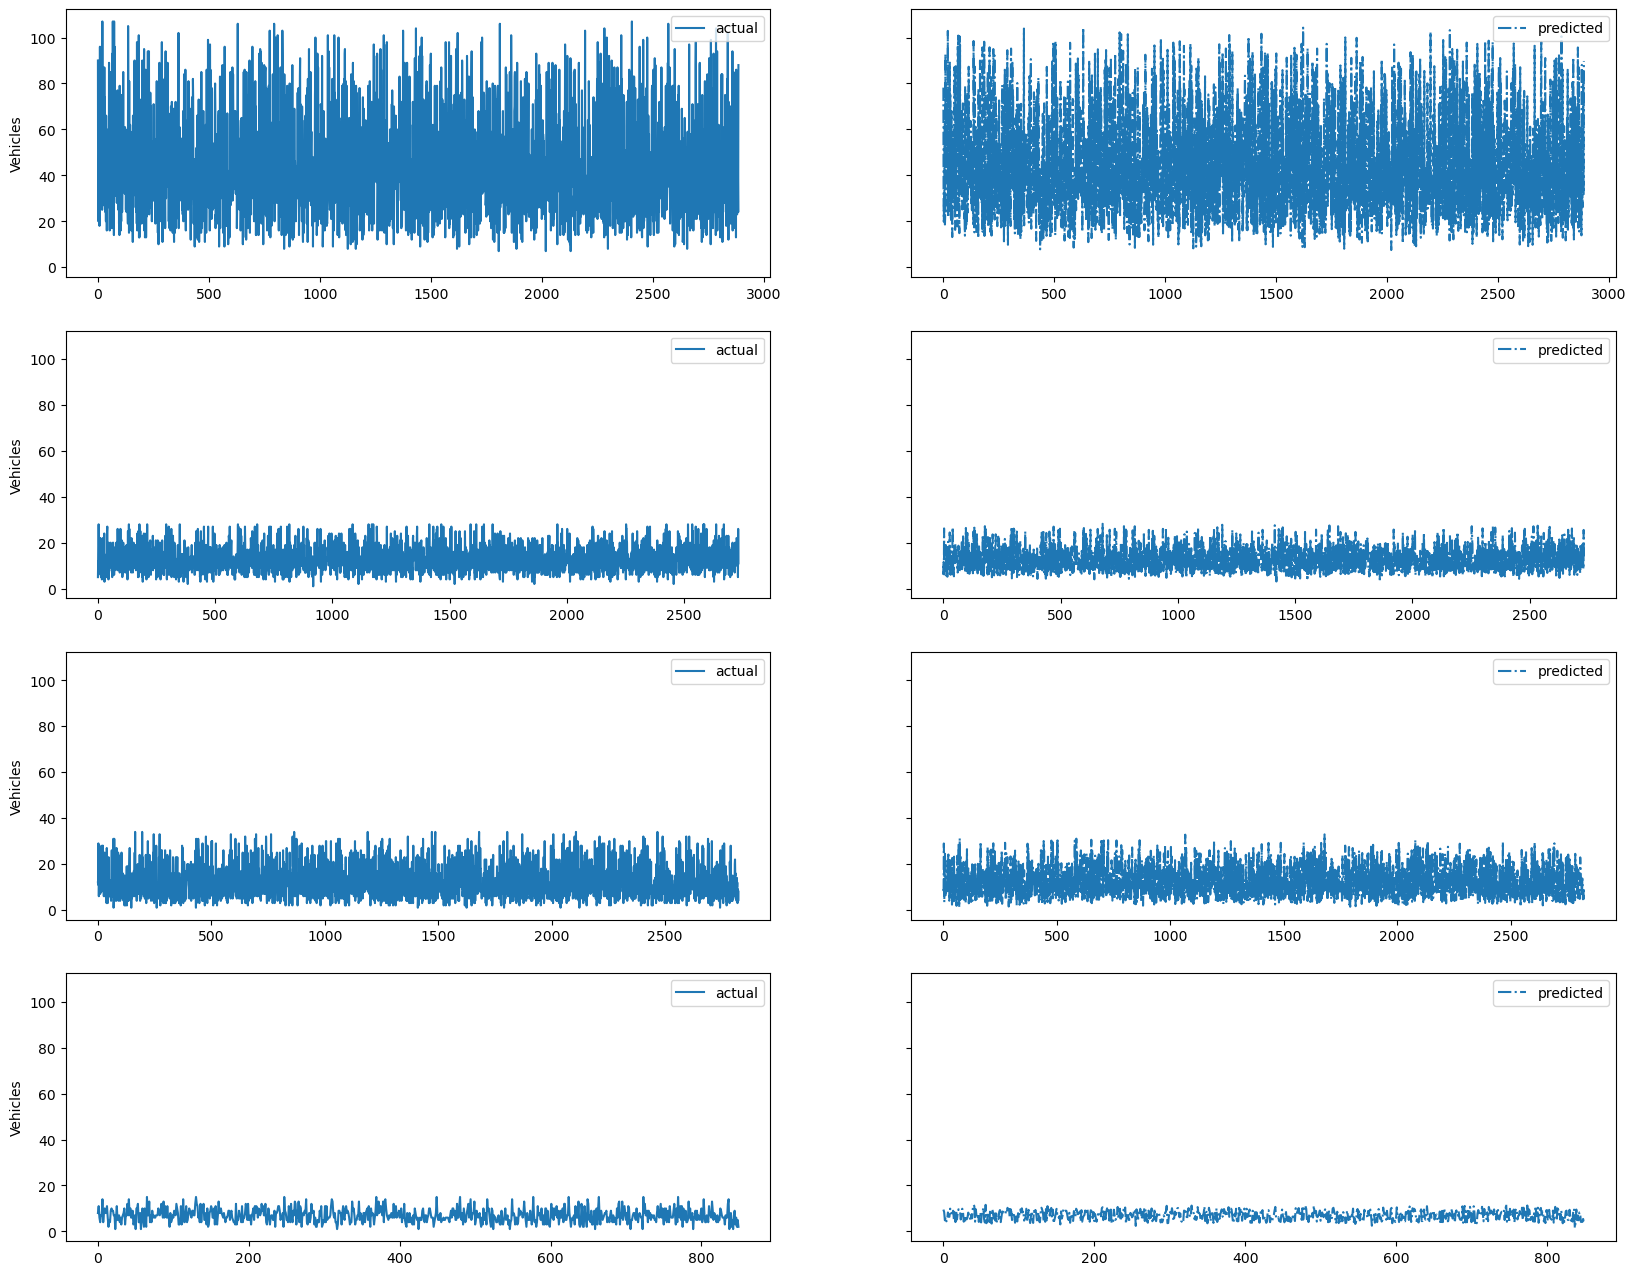

In [26]:
show1( [xgbs[i].y_test for i in range(4)], res2)

## 4.3 LSTM

### Slinding Window for LSTM

In [27]:
def create_sequences(df, n_steps=24):
    X = []
    y = []
    for i in range(n_steps, df.shape[0]):
        X.append(df[i-n_steps:i, :])
        y.append(df[i, :])
    return np.array(X), np.array(y)

Epoch 1/3
11524/11524 [==============================] - 48s 4ms/step - loss: 0.0974
Epoch 2/3
11524/11524 [==============================] - 46s 4ms/step - loss: 0.0629
Epoch 3/3
90/90 [==============================] - 1s 3ms/step
Epoch 1/3
10903/10903 [==============================] - 45s 4ms/step - loss: 0.0178
Epoch 2/3
10903/10903 [==============================] - 43s 4ms/step - loss: 0.0142
Epoch 3/3
85/85 [==============================] - 1s 2ms/step
Epoch 1/3
11271/11271 [==============================] - 46s 4ms/step - loss: 0.0350
Epoch 2/3
11271/11271 [==============================] - 44s 4ms/step - loss: 0.0276
Epoch 3/3
88/88 [==============================] - 1s 3ms/step
Epoch 1/3
3373/3373 [==============================] - 14s 4ms/step - loss: 0.0216
Epoch 2/3
3373/3373 [==============================] - 13s 4ms/step - loss: 0.0157
Epoch 3/3
26/26 [==============================] - 0s 2ms/step


RMSE       MAE       R^2
Junction 1  0.297398  0.223477  0.917280
Junction 2  0.175861  0.139252  0.454369
Junction 3  0.169654  0.127656  0.771650
Junction 4  0.112633  0.089383  0.466005

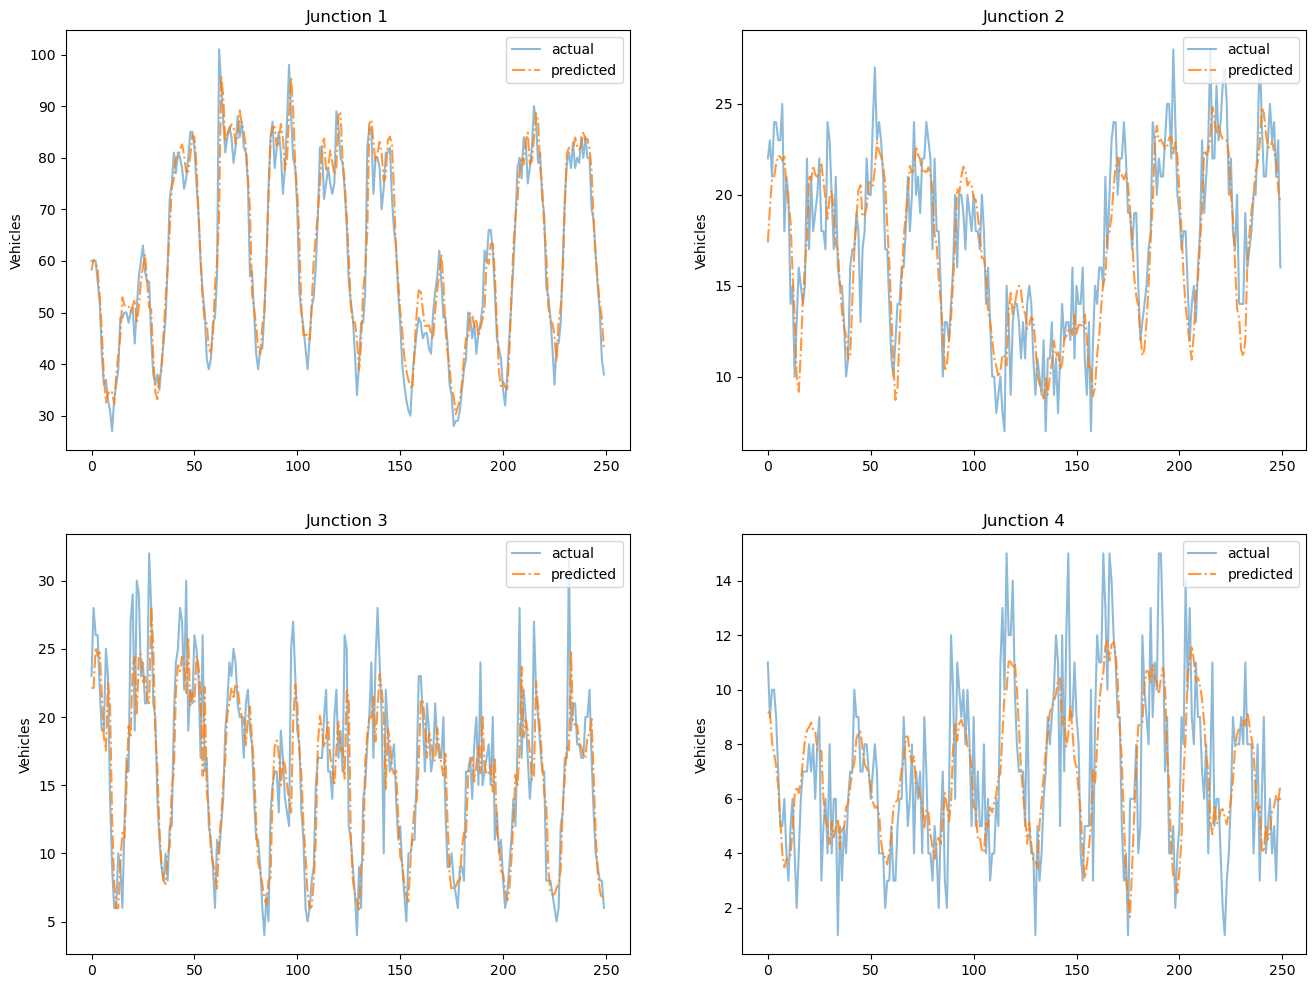

In [28]:
table_lstm = pd.DataFrame(np.zeros((4, 3)), columns=['RMSE', 'MAE', 'R^2'], index=[f'Junction {i}' for i in range(1, 5)])
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
res = []
Y_test = []

for i in range(4):
    train_size = int(data[i].shape[0] * 0.8)
    train = data[i][['Vehicles']].values[:train_size]
    test = data[i][['Vehicles']].values[train_size:]

    X_train, y_train = create_sequences(train)
    X_test, y_test = create_sequences(test)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')


    model.fit(X_train, y_train, epochs=3, batch_size=1, verbose=1)
    y_predict = model.predict(X_test)
    #mse = MSE(y_test, y_predict)
    rmse = MSE(y_test, y_predict, squared=False)
    mae = MAE(y_test, y_predict)
    r2_value = r2_score(y_test, y_predict)
    table_lstm.loc[f'Junction {i+1}'] = [rmse, mae, r2_value]

    res.append(y_predict)
    Y_test.append(y_test)

    cur_ax = ax[i // 2][i % 2]
    show(y_test, y_predict, ax=cur_ax, i=i+1)

table_lstm

# 5. Performace Comparison

In [29]:
table_rf['Model'] = 'Random Forest'
table_xbg['Model'] = 'XGBoost'
table_lstm['Model'] = 'LSTM'


table_rf.reset_index(inplace=True)
table_rf = table_rf.rename(columns={'index': 'Junction'})
table_xbg.reset_index(inplace=True)
table_xbg = table_xbg.rename(columns={'index': 'Junction'})
table_lstm.reset_index(inplace=True)
table_lstm = table_lstm.rename(columns={'index': 'Junction'})

In [30]:
res_table = pd.concat([table_rf, table_xbg, table_lstm])
res_table
cmp_table = res_table.pivot(index='Junction', columns='Model', values=['RMSE', 'MAE', 'R^2'])
cmp_table

RMSE                               MAE                \
Model           LSTM Random Forest   XGBoost      LSTM Random Forest   
Junction                                                               
Junction 1  0.297398      0.185797  0.160826  0.223477      0.136094   
Junction 2  0.175861      0.099772  0.096871  0.139252      0.080631   
Junction 3  0.169654      0.152084  0.144437  0.127656      0.114155   
Junction 4  0.112633      0.096277  0.097251  0.089383      0.077159   

                           R^2                          
Model        XGBoost      LSTM Random Forest   XGBoost  
Junction                                                
Junction 1  0.118774  0.917280      0.968583  0.976460  
Junction 2  0.078442  0.454369      0.854158  0.862516  
Junction 3  0.109803  0.771650      0.806105  0.825113  
Junction 4  0.077759  0.466005      0.550362  0.541212

In [31]:
cmp_table.loc['Average'] = cmp_table.mean()

In [32]:
cmp_table.mean()

      Model        
RMSE  LSTM             0.188887
      Random Forest    0.133482
      XGBoost          0.124846
MAE   LSTM             0.144942
      Random Forest    0.102010
      XGBoost          0.096194
R^2   LSTM             0.652326
      Random Forest    0.794802
      XGBoost          0.801326
dtype: float64

In [33]:
cmp_table

RMSE                               MAE                \
Model           LSTM Random Forest   XGBoost      LSTM Random Forest   
Junction                                                               
Junction 1  0.297398      0.185797  0.160826  0.223477      0.136094   
Junction 2  0.175861      0.099772  0.096871  0.139252      0.080631   
Junction 3  0.169654      0.152084  0.144437  0.127656      0.114155   
Junction 4  0.112633      0.096277  0.097251  0.089383      0.077159   
Average     0.188887      0.133482  0.124846  0.144942      0.102010   

                           R^2                          
Model        XGBoost      LSTM Random Forest   XGBoost  
Junction                                                
Junction 1  0.118774  0.917280      0.968583  0.976460  
Junction 2  0.078442  0.454369      0.854158  0.862516  
Junction 3  0.109803  0.771650      0.806105  0.825113  
Junction 4  0.077759  0.466005      0.550362  0.541212  
Average     0.096194  0.652326      0.794802  0.801326

# 6. Additional Feature Creation

Creating more features such as lag data and mean and standard deviation might be helpful to improve the models' performance

In [34]:
df['lag_1'] = df.groupby('Junction')['Vehicles'].shift(1)
df['lag_2'] = df.groupby('Junction')['Vehicles'].shift(2)
df['lag_3'] = df.groupby('Junction')['Vehicles'].shift(3)

df['mean_3'] = df.groupby('Junction', as_index=False)['Vehicles'].apply(lambda x: x.rolling(window=3).mean()).reset_index().drop(columns='level_0').set_index('DateTime')

df['std_3'] = df.groupby('Junction', as_index=False)['Vehicles'].apply(lambda x: x.rolling(window=3).std()).reset_index().drop(columns='level_0').set_index('DateTime')
df.dropna(inplace=True)
df.head()

Junction  Vehicles  year  month  day  hour  day_of_week  \
DateTime                                                                       
2015-11-01 03:00:00         1         7  2015     11    1     3            6   
2015-11-01 04:00:00         1         9  2015     11    1     4            6   
2015-11-01 05:00:00         1         6  2015     11    1     5            6   
2015-11-01 06:00:00         1         9  2015     11    1     6            6   
2015-11-01 07:00:00         1         8  2015     11    1     7            6   

                     lag_1  lag_2  lag_3     mean_3     std_3  
DateTime                                                       
2015-11-01 03:00:00   10.0   13.0   15.0  10.000000  3.000000  
2015-11-01 04:00:00    7.0   10.0   13.0   8.666667  1.527525  
2015-11-01 05:00:00    9.0    7.0   10.0   7.333333  1.527525  
2015-11-01 06:00:00    6.0    9.0    7.0   8.000000  1.732051  
2015-11-01 07:00:00    9.0    6.0    9.0   7.666667  1.527525

In [35]:
df_tr = StandardScaler().fit_transform(df)
df_tr = pd.DataFrame(df_tr, columns=df.columns, index=df.index)

In [36]:
data = [df_tr[df['Junction'] == i] for i in range(1, 5)]
data = [remove_outliers(d, 'Vehicles') for d in data]
data[1]

Junction  Vehicles      year     month       day  \
DateTime                                                                
2015-11-01 03:00:00 -0.186649 -0.809378 -2.062078  1.433402 -1.674380   
2015-11-01 04:00:00 -0.186649 -0.761187 -2.062078  1.433402 -1.674380   
2015-11-01 05:00:00 -0.186649 -1.002141 -2.062078  1.433402 -1.674380   
2015-11-01 06:00:00 -0.186649 -0.905759 -2.062078  1.433402 -1.674380   
2015-11-01 07:00:00 -0.186649 -0.905759 -2.062078  1.433402 -1.674380   
...                       ...       ...       ...       ...       ...   
2017-06-30 09:00:00 -0.186649  0.106248  1.185244  0.032600  1.627827   
2017-06-30 10:00:00 -0.186649  0.106248  1.185244  0.032600  1.627827   
2017-06-30 11:00:00 -0.186649  0.250820  1.185244  0.032600  1.627827   
2017-06-30 12:00:00 -0.186649  0.250820  1.185244  0.032600  1.627827   
2017-06-30 23:00:00 -0.186649  0.202629  1.185244  0.032600  1.627827   

                         hour  day_of_week     lag_1     lag_2     lag_3  \
DateTime                                                                   
2015-11-01 03:00:00 -1.228516     1.502608 -0.857484 -0.809209 -0.809150   
2015-11-01 04:00:00 -1.084029     1.502608 -0.809290 -0.857405 -0.809150   
2015-11-01 05:00:00 -0.939542     1.502608 -0.761097 -0.809209 -0.857350   
2015-11-01 06:00:00 -0.795055     1.502608 -1.002064 -0.761012 -0.809150   
2015-11-01 07:00:00 -0.650569     1.502608 -0.905677 -1.001995 -0.760949   
...                       ...          ...       ...       ...       ...   
2017-06-30 09:00:00 -0.361595     0.502449 -0.279162 -0.182653 -0.230738   
2017-06-30 10:00:00 -0.217109     0.502449  0.106386 -0.279046 -0.182537   
2017-06-30 11:00:00 -0.072622     0.502449  0.106386  0.106527 -0.278939   
2017-06-30 12:00:00  0.071865     0.502449  0.250966  0.106527  0.106669   
2017-06-30 23:00:00  1.661219     0.502449  0.299160  0.395707  0.588678   

                       mean_3     std_3  
DateTime                                 
2015-11-01 03:00:00 -0.836833 -0.796139  
2015-11-01 04:00:00 -0.820545 -0.654353  
2015-11-01 05:00:00 -0.869409 -0.102253  
2015-11-01 06:00:00 -0.901984 -0.145575  
2015-11-01 07:00:00 -0.950848 -0.602456  
...                       ...       ...  
2017-06-30 09:00:00 -0.120165  0.406850  
2017-06-30 10:00:00 -0.022437  0.559647  
2017-06-30 11:00:00  0.156730 -0.408772  
2017-06-30 12:00:00  0.205593 -0.408772  
2017-06-30 23:00:00  0.303321 -0.318883  

[13656 rows x 12 columns]

0 [ 2.2875988   0.67444307  0.5355246  ...  3.0228581  -0.02410262
  1.1530465 ]
y_test: DateTime
2016-12-19 22:00:00    2.274834
2016-02-18 13:00:00    0.684537
2016-07-13 09:00:00    0.539965
2016-04-02 23:00:00    0.443583
2017-01-27 08:00:00    0.877301
                         ...   
2015-12-21 13:00:00    0.539965
2016-07-26 07:00:00    0.250820
2017-02-15 11:00:00    2.997696
2016-02-02 09:00:00    0.009866
2016-06-30 23:00:00    1.118255
Name: Vehicles, Length: 2887, dtype: float64
1 [-0.711721   -0.28605083 -0.85419434 ... -0.71411973 -0.24044079
 -0.22435799]
y_test: DateTime
2016-08-14 09:00:00   -0.712996
2016-06-02 14:00:00   -0.279279
2016-08-27 09:00:00   -0.857569
2017-02-27 23:00:00    0.250820
2017-02-22 10:00:00   -0.086516
                         ...   
2016-08-26 14:00:00   -0.423851
2016-06-16 21:00:00   -0.279279
2016-03-28 04:00:00   -0.712996
2017-06-21 06:00:00   -0.231088
2016-06-16 17:00:00   -0.231088
Name: Vehicles, Length: 2732, dtype: float64
2 [-0.2726

RMSE       MAE       R^2
Junction 1  0.045093  0.029817  0.998114
Junction 2  0.014624  0.008227  0.996833
Junction 3  0.025826  0.015545  0.994418
Junction 4  0.018735  0.012823  0.983928

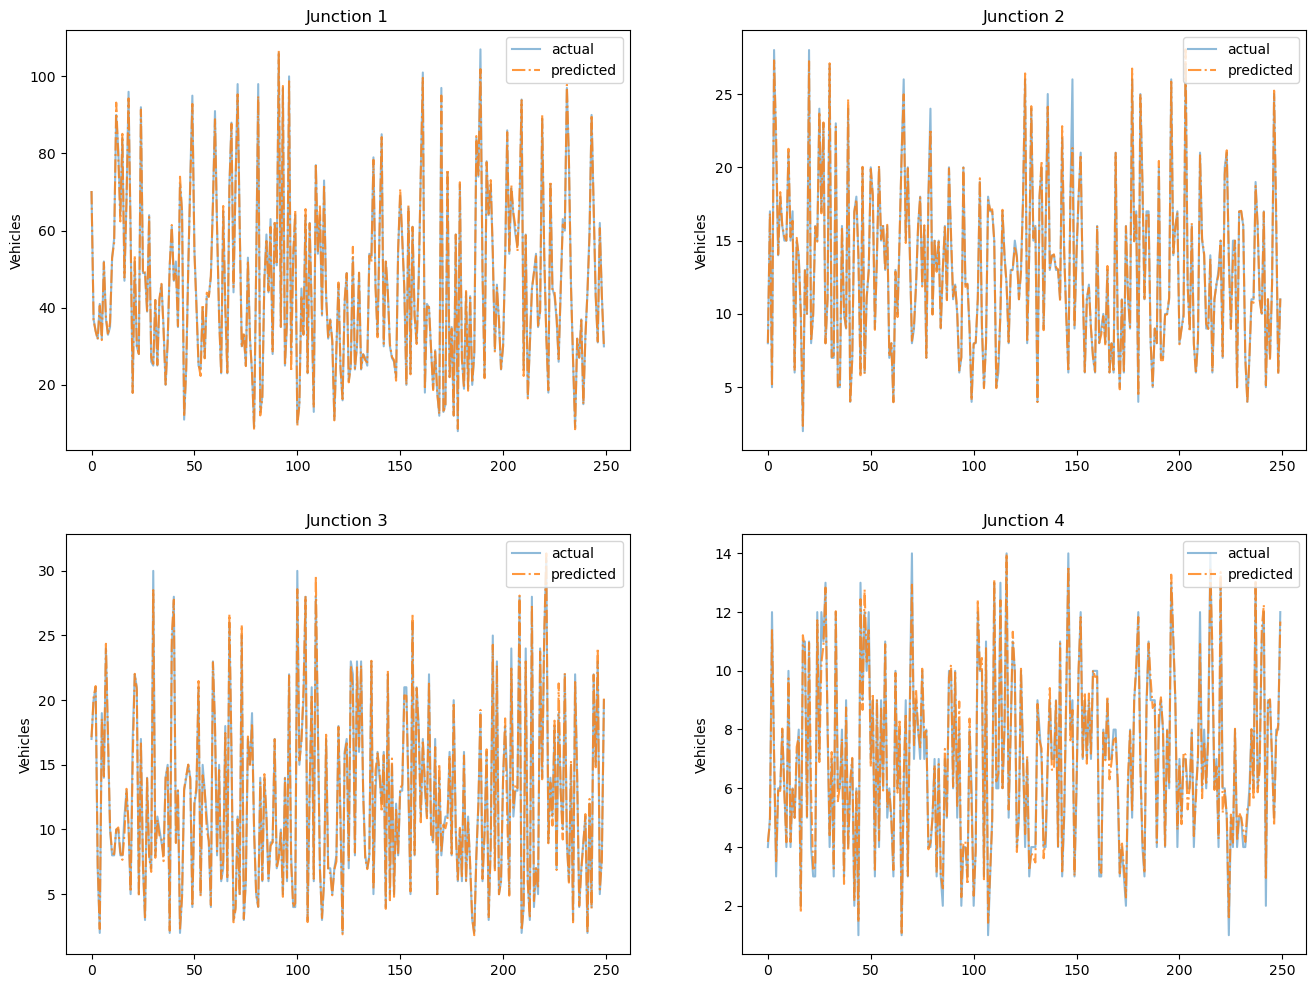

In [37]:
table_xbg = pd.DataFrame(np.zeros((4, 3)), columns=['RMSE', 'MAE', 'R^2'], index=[f'Junction {i}' for i in range(1, 5)])
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [3, 5, 7, 9],
              'eta': [0.01, 0.1, 0.2, 0.3],
              'subsample': [0.8, 1],
            }

xgbs = []
res2 = []

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
for i in range(4):
    model = Model(XGBRegressor(objective='reg:squarederror', random_state=42), data[i], 0.2, 
    data[i].columns.drop(['Junction', 'Vehicles']), 'Vehicles',
    f'Junction {i+1}', param_grid)
    y_predict, table_xbg = model.run(table_xbg)
    res2.append(y_predict)
    xgbs.append(model)

    print(i, y_predict)
    print('y_test:', model.y_test)

    cur_ax = ax[i // 2][i % 2]
    show(model.y_test,y_predict, ax=cur_ax, i=i+1)

table_xbg